### Task: 4-digit number Addition "a + b = c"
### Trained 6L transformer from scratch

In [2]:
# Config

k = 4. # number of digits - 1000 to 9999
num_samples = 75000

frac_train = 0.6
frac_val = 0.2

SEED = 42

#Define Task

*   Define input and output ("a + b =" and "c")



In [3]:
import random

def generate_dataset(num_samples, seed = 42):
    random.seed(seed)
    dataset = set()

    while len(dataset) < num_samples:
      a = random.randint(1000, 9999)
      b = random.randint(1000, 9999)

      c = a + b  #Addition

      input_str = f"{a} + {b} ="
      output_str = str(c)

      dataset.add((input_str, output_str))

    return list(dataset)

dataset = generate_dataset(num_samples, seed=SEED)
print(f"Length of dataset: {len(dataset)}")

Length of dataset: 75000


In [4]:
# Train, val, test split
random.seed(SEED)
random.shuffle(dataset)

train_end = int(num_samples * frac_train)
val_end = train_end + int(num_samples * frac_val)

train_data = dataset[:train_end]
val_data = dataset[train_end:val_end]
test_data = dataset[val_end:]

print(len(train_data))
print(len(val_data))
print(len(test_data))

45000
15000
15000


In [5]:
print(train_data[:5])

[('6304 + 1258 =', '7562'), ('4195 + 2055 =', '6250'), ('7245 + 2566 =', '9811'), ('4194 + 1347 =', '5541'), ('2346 + 8568 =', '10914')]


#Training


*   Character Tokenizer
*   Transformer Model
*   Training Functions



In [12]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import math
import os
from tqdm import tqdm
import matplotlib.pyplot as plt

In [7]:
# tokenizer

class CharacterTokenizer:
    """Character-level tokenizer for addition"""
    def __init__(self):
        self.chars = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ' ', '+', '=']
        self.PAD_TOKEN = '<PAD>'
        self.BOS_TOKEN = '<BOS>'
        self.EOS_TOKEN = '<EOS>'

        self.vocab = [self.PAD_TOKEN, self.BOS_TOKEN, self.EOS_TOKEN] + self.chars
        self.char_to_idx = {char: idx for idx, char in enumerate(self.vocab)}
        self.idx_to_char = {idx: char for idx, char in enumerate(self.vocab)}

        self.vocab_size = len(self.vocab)
        self.pad_idx = self.char_to_idx[self.PAD_TOKEN]
        self.bos_idx = self.char_to_idx[self.BOS_TOKEN]
        self.eos_idx = self.char_to_idx[self.EOS_TOKEN]

    def encode(self, text, add_special_tokens=True):
        """Convert text to token indices"""
        tokens = [self.char_to_idx[char] for char in text]
        if add_special_tokens:
            tokens = [self.bos_idx] + tokens + [self.eos_idx]
        return tokens

    def decode(self, indices):
        """Convert token indices back to text"""
        chars = [self.idx_to_char[idx] for idx in indices
                 if idx not in [self.pad_idx, self.bos_idx, self.eos_idx]]
        return ''.join(chars)

# Dataset preparation - convert to tokens

class AdditionDataset(Dataset):
    def __init__(self, data, tokenizer, max_length=32, ignore_index=-100):
        self.data = data
        self.tokenizer = tokenizer
        self.max_length = max_length
        self.ignore_index = ignore_index

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        input_str, output_str = self.data[idx]

        full_sequence = input_str + " " + output_str  # "2506 + 7036 = 9542"
        prompt = input_str + " "                       # "2506 + 7036 = "

        full_tokens = self.tokenizer.encode(full_sequence)
        prompt_len = len(self.tokenizer.encode(prompt))

        # Pad if needed
        if len(full_tokens) < self.max_length:
            full_tokens = full_tokens + [self.tokenizer.pad_idx] * (self.max_length - len(full_tokens))
        else:
            full_tokens = full_tokens[:self.max_length]

        # Shift for autoregressive
        input_ids = torch.tensor(full_tokens[:-1], dtype=torch.long)
        labels = torch.tensor(full_tokens[1:], dtype=torch.long)

        # Mask prompt portion
        # In labels, the prompt occupies positions 0 to (prompt_len - 2) because of the shift
        labels[:prompt_len - 2] = self.ignore_index

        # Mask padding
        labels[labels == self.tokenizer.pad_idx] = self.ignore_index

        return input_ids, labels

In [9]:
## Debug to checking if input tokens are masked properly so that loss computation happens only over output tokens (along with EOS)

def check_masking(dataset, tokenizer, num_samples=3):
    """Verify that masking is happening correctly in the dataset"""

    print("MASKING VERIFICATION")

    for i in range(num_samples):
        input_ids, labels = dataset[i]

        print(f"\n{'='*80}")
        print(f"SAMPLE {i+1}")
        print(f"{'='*80}")

        # Decode input_ids
        input_tokens = [tokenizer.idx_to_char[idx.item()] for idx in input_ids]

        # Decode labels (including masked positions)
        label_tokens = []
        for idx in labels:
            if idx.item() == dataset.ignore_index:
                label_tokens.append('<MASK>')
            else:
                label_tokens.append(tokenizer.idx_to_char[idx.item()])

        print(f"\nInput IDs (what model sees):")
        print(f"Tokens: {input_tokens}")
        print(f"Indices: {input_ids.tolist()}")

        print(f"\nLabels (what model should predict):")
        print(f"Tokens: {label_tokens}")
        print(f"Indices: {labels.tolist()}")

        # Visual alignment
        print(f"\nAlignment (input -> label):")
        print(f"Position:  ", end="")
        for j in range(len(input_ids)):
            print(f"{j:>8}", end="")
        print()

        print(f"Input:     ", end="")
        for token in input_tokens:
            print(f"{token:>8}", end="")
        print()

        print(f"Label:     ", end="")
        for token in label_tokens:
            print(f"{token:>8}", end="")
        print()

        # Count masked vs unmasked
        num_masked = (labels == dataset.ignore_index).sum().item()
        num_unmasked = (labels != dataset.ignore_index).sum().item()
        num_answer = num_unmasked - (labels == tokenizer.pad_idx).sum().item()

        print(f"\nStatistics:")
        print(f"  Total positions: {len(labels)}")
        print(f"  Masked (prompt): {num_masked}")
        print(f"  Unmasked (answer + padding): {num_unmasked}")
        print(f"  Answer tokens only: {num_answer}")

        # Extract and show only the answer part
        answer_mask = (labels != dataset.ignore_index) & (labels != tokenizer.pad_idx)
        answer_indices = labels[answer_mask]
        answer_tokens = [tokenizer.idx_to_char[idx.item()] for idx in answer_indices]

        print(f"\nExtracted Answer (what loss is computed on):")
        print(f"  Tokens: {answer_tokens}")
        print(f"  As string: {''.join(answer_tokens)}")

# Usage:
tokenizer = CharacterTokenizer()
train_dataset = AdditionDataset(train_data, tokenizer, max_length=32)

check_masking(train_dataset, tokenizer, num_samples=2)

MASKING VERIFICATION

SAMPLE 1

Input IDs (what model sees):
Tokens: ['<BOS>', '6', '3', '0', '4', ' ', '+', ' ', '1', '2', '5', '8', ' ', '=', ' ', '7', '5', '6', '2', '<EOS>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>', '<PAD>']
Indices: [1, 9, 6, 3, 7, 13, 14, 13, 4, 5, 8, 11, 13, 15, 13, 10, 8, 9, 5, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

Labels (what model should predict):
Tokens: ['<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '7', '5', '6', '2', '<EOS>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>', '<MASK>']
Indices: [-100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, 10, 8, 9, 5, 2, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100, -100]

Alignment (input -> label):
Position:         0       1       2       3       4       5       

In [10]:
# Transformer Model - Currently using Learned Positional Encoding.
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]

class LearnedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=512):
        super().__init__()
        self.pos_embedding = nn.Embedding(max_len, d_model)
        nn.init.uniform_(self.pos_embedding.weight, -0.1, 0.1)

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        # Create position indices [0, 1, 2, ..., seq_len-1]
        positions = torch.arange(0, seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        # Add learned positional embeddings
        return x + self.pos_embedding(positions)

class TransformerModel(nn.Module):
    def __init__(self, vocab_size, d_model=128, nhead=4, num_layers=6,
                 dim_feedforward=512, dropout=0.1, max_len=512, pos_encoding='learned'):
        super().__init__()

        self.d_model = d_model
        self.embedding = nn.Embedding(vocab_size, d_model)

        if pos_encoding == 'learned':
            self.pos_encoder = LearnedPositionalEncoding(d_model, max_len)
        elif pos_encoding == 'sinusoidal':
            self.pos_encoder = PositionalEncoding(d_model, max_len)
        else:
            raise ValueError(f"Unknown pos_encoding: {pos_encoding}")

        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=nhead,
            dim_feedforward=dim_feedforward,
            dropout=dropout,
            batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)

        self.fc_out = nn.Linear(d_model, vocab_size)
        self.dropout = nn.Dropout(dropout)

        self._init_weights()

    def _init_weights(self):
        initrange = 0.1
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc_out.bias.data.zero_()
        self.fc_out.weight.data.uniform_(-initrange, initrange)

    def generate_square_subsequent_mask(self, sz):
        """Causal mask for autoregressive generation"""
        mask = torch.triu(torch.ones(sz, sz), diagonal=1).bool()
        return mask

    def forward(self, src, src_mask=None):
        src = self.embedding(src) * math.sqrt(self.d_model)
        src = self.pos_encoder(src)
        src = self.dropout(src)

        # Create causal mask
        seq_len = src.size(1)
        causal_mask = self.generate_square_subsequent_mask(seq_len).to(src.device)

        # Use TransformerEncoder with causal mask
        output = self.transformer(
            src,
            mask=causal_mask,  # Attention mask (causal)
            src_key_padding_mask=src_mask  # Padding mask
        )
        output = self.fc_out(output)

        return output


In [11]:
# Training Functions
def train_epoch(model, train_loader, optimizer, criterion, device, scheduler=None, grad_clip=1.0):
    """Train for one epoch"""
    model.train()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    total_correct_seqs = 0
    total_seqs = 0

    for batch_idx, (input_ids, target_ids) in enumerate(tqdm(train_loader, desc="Training")):
        input_ids = input_ids.to(device)
        target_ids = target_ids.to(device)
        # In train_epoch() and evaluate():
        pad_mask = (input_ids == tokenizer.pad_idx)

        optimizer.zero_grad()
        logits = model(input_ids, src_mask=pad_mask)
        loss = criterion(logits.reshape(-1, logits.size(-1)), target_ids.reshape(-1))
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), grad_clip)
        optimizer.step()

        if scheduler is not None:
            scheduler.step()

        total_loss += loss.item()

        # Character accuracy
        predictions = logits.argmax(dim=-1)
        mask = target_ids != -100
        correct = (predictions == target_ids) & mask
        total_correct_chars += correct.sum().item()
        total_chars += mask.sum().item()

        # Sequence accuracy
        for pred_seq, label_seq in zip(predictions, target_ids):
            output_mask = label_seq != -100
            if output_mask.sum() > 0:
                if torch.equal(pred_seq[output_mask], label_seq[output_mask]):
                    total_correct_seqs += 1
                total_seqs += 1

    avg_loss = total_loss / len(train_loader)
    char_accuracy = total_correct_chars / total_chars
    seq_accuracy = total_correct_seqs / total_seqs if total_seqs > 0 else 0.0

    return avg_loss, char_accuracy, seq_accuracy


def evaluate(model, val_loader, criterion, tokenizer, device):
    """Evaluate on validation/test set"""
    model.eval()
    total_loss = 0
    total_correct_chars = 0
    total_chars = 0
    total_correct_sequences = 0
    total_sequences = 0

    with torch.no_grad():
        for input_ids, labels in tqdm(val_loader, desc="Evaluating"):
            input_ids = input_ids.to(device)
            labels = labels.to(device)
            pad_mask = (input_ids == tokenizer.pad_idx)
            logits = model(input_ids, src_mask=pad_mask)

            loss = criterion(
                logits.view(-1, logits.size(-1)),
                labels.view(-1)
            )
            total_loss += loss.item()

            predictions = logits.argmax(dim=-1)

            # Character accuracy (only on non-masked tokens(output))
            mask = labels != criterion.ignore_index
            correct_chars = (predictions == labels) & mask
            total_correct_chars += correct_chars.sum().item()
            total_chars += mask.sum().item()

            # Sequence accuracy
            for pred_seq, label_seq in zip(predictions, labels):
                # Extract only output tokens (non-masked)
                output_mask = label_seq != criterion.ignore_index
                pred_output = pred_seq[output_mask]
                label_output = label_seq[output_mask]

                if torch.equal(pred_output, label_output):
                    total_correct_sequences += 1
                total_sequences += 1

    avg_loss = total_loss / len(val_loader)
    char_accuracy = total_correct_chars / total_chars
    seq_accuracy = total_correct_sequences / total_sequences

    return avg_loss, char_accuracy, seq_accuracy


In [19]:
def train_model(model, train_loader, val_loader, optimizer, scheduler, criterion,
                tokenizer, device, num_epochs, save_path='best_model.pt'):
    """Main training loop with early stopping"""

    best_train_seq_acc = 0.0

    history = {
        'train_loss': [],
        'train_seq_acc': [],
        'val_loss': [],
        'val_seq_acc': []
    }

    for epoch in range(num_epochs):
        print(f"EPOCH {epoch + 1}/{num_epochs}")

        # Training
        train_loss, train_char_acc, train_seq_acc = train_epoch(
            model, train_loader, optimizer, criterion, device, scheduler
        )

        # Validation
        val_loss, val_char_acc, val_seq_acc = evaluate(
            model, val_loader, criterion, tokenizer, device
        )

        history['train_loss'].append(train_loss)
        history['train_seq_acc'].append(train_seq_acc)
        history['val_loss'].append(val_loss)
        history['val_seq_acc'].append(val_seq_acc)

        # Print metrics
        print(f"Train: Loss={train_loss:.4f}, SeqAcc={train_seq_acc:.4f}")
        print(f"Val:   Loss={val_loss:.4f}, SeqAcc={val_seq_acc:.4f}")

        # Since model is generalizing better at val, focused on how training improves and made sure validation is decent
        if train_seq_acc >= best_train_seq_acc and val_seq_acc >= 0.99:
            best_train_seq_acc = train_seq_acc
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_seq_acc': train_seq_acc,
                'val_seq_acc': val_seq_acc,
            }, save_path)
            print(f"Saved (TrainSeqAcc: {train_seq_acc:.4f})")

        # Stop if train is perfect
        if train_seq_acc >= 1.0 and val_seq_acc >= 0.99:
            print(f"Reached 100% training accuracy at epoch {epoch+1}!")
            break

    if not os.path.exists(save_path):
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'train_seq_acc': train_seq_acc,
            'val_seq_acc': val_seq_acc,
        }, save_path)

    # Load best model
    checkpoint = torch.load(save_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\n model saved at: TrainSeq={checkpoint['train_seq_acc']:.4f}, ValSeq={checkpoint['val_seq_acc']:.4f}")

    return history

In [26]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Initialize tokenizer
tokenizer = CharacterTokenizer()
print(f"Vocabulary size: {tokenizer.vocab_size}")

# Create datasets
train_dataset = AdditionDataset(train_data, tokenizer, max_length=32)
val_dataset = AdditionDataset(val_data, tokenizer, max_length=32)
test_dataset = AdditionDataset(test_data, tokenizer, max_length=32)

# Create dataloaders
batch_size = 128
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

# Initialize model
model = TransformerModel(
    vocab_size=tokenizer.vocab_size,
    d_model=128,
    nhead=4,
    num_layers=6,
    dim_feedforward=512,
    dropout=0.1,
    max_len=32
).to(device)

# Count parameters
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params:,}")

# Loss and optimizer
criterion = nn.CrossEntropyLoss(ignore_index=-100)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-5)

# Learning rate scheduler
def lr_lambda(step):
    warmup_steps = 1000
    if step < warmup_steps:
        return step / warmup_steps
    return 0.5 ** ((step - warmup_steps) / 5000)

scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

# Train
history = train_model(
    model=model,
    train_loader=train_loader,
    val_loader=val_loader,
    optimizer=optimizer,
    scheduler=scheduler,
    criterion=criterion,
    tokenizer=tokenizer,
    device=device,
    num_epochs=30,
    save_path='best_model.pt'
)

Using device: cuda
Vocabulary size: 16
Total parameters: 1,197,840
EPOCH 1/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.58it/s]


Train: Loss=1.9715, SeqAcc=0.0000
Val:   Loss=1.5515, SeqAcc=0.0005
EPOCH 2/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 26.33it/s]


Train: Loss=1.4383, SeqAcc=0.0004
Val:   Loss=1.3373, SeqAcc=0.0010
EPOCH 3/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.58it/s]


Train: Loss=1.3368, SeqAcc=0.0009
Val:   Loss=1.2846, SeqAcc=0.0013
EPOCH 4/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.22it/s]


Train: Loss=1.1544, SeqAcc=0.0038
Val:   Loss=0.8945, SeqAcc=0.0098
EPOCH 5/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 28.89it/s]


Train: Loss=0.9030, SeqAcc=0.0139
Val:   Loss=0.6655, SeqAcc=0.0460
EPOCH 6/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 21.87it/s]


Train: Loss=0.6343, SeqAcc=0.0562
Val:   Loss=0.4742, SeqAcc=0.0933
EPOCH 7/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 23.88it/s]


Train: Loss=0.4982, SeqAcc=0.1130
Val:   Loss=0.2782, SeqAcc=0.4079
EPOCH 8/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.42it/s]


Train: Loss=0.1910, SeqAcc=0.6340
Val:   Loss=0.0238, SeqAcc=0.9742
EPOCH 9/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 21.20it/s]


Train: Loss=0.0805, SeqAcc=0.8577
Val:   Loss=0.0035, SeqAcc=0.9999
Saved (TrainSeqAcc: 0.8577)
EPOCH 10/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 26.06it/s]


Train: Loss=0.0596, SeqAcc=0.8969
Val:   Loss=0.0036, SeqAcc=0.9941
Saved (TrainSeqAcc: 0.8969)
EPOCH 11/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 26.68it/s]


Train: Loss=0.0470, SeqAcc=0.9178
Val:   Loss=0.0047, SeqAcc=0.9939
Saved (TrainSeqAcc: 0.9178)
EPOCH 12/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 22.86it/s]


Train: Loss=0.0388, SeqAcc=0.9316
Val:   Loss=0.0063, SeqAcc=0.9905
Saved (TrainSeqAcc: 0.9316)
EPOCH 13/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.34it/s]


Train: Loss=0.0315, SeqAcc=0.9451
Val:   Loss=0.0009, SeqAcc=0.9999
Saved (TrainSeqAcc: 0.9451)
EPOCH 14/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 22.81it/s]


Train: Loss=0.0285, SeqAcc=0.9513
Val:   Loss=0.0024, SeqAcc=0.9995
Saved (TrainSeqAcc: 0.9513)
EPOCH 15/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.26it/s]


Train: Loss=0.0255, SeqAcc=0.9553
Val:   Loss=0.0003, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9553)
EPOCH 16/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 22.35it/s]


Train: Loss=0.0202, SeqAcc=0.9657
Val:   Loss=0.0002, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9657)
EPOCH 17/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 23.16it/s]


Train: Loss=0.0194, SeqAcc=0.9664
Val:   Loss=0.0002, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9664)
EPOCH 18/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 29.48it/s]


Train: Loss=0.0170, SeqAcc=0.9716
Val:   Loss=0.0002, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9716)
EPOCH 19/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 30.64it/s]


Train: Loss=0.0145, SeqAcc=0.9764
Val:   Loss=0.0003, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9764)
EPOCH 20/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 30.60it/s]


Train: Loss=0.0120, SeqAcc=0.9805
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9805)
EPOCH 21/30


Evaluating: 100%|██████████| 118/118 [00:03<00:00, 30.32it/s]


Train: Loss=0.0141, SeqAcc=0.9760
Val:   Loss=0.0003, SeqAcc=0.9999
EPOCH 22/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 23.94it/s]


Train: Loss=0.0120, SeqAcc=0.9804
Val:   Loss=0.0003, SeqAcc=1.0000
EPOCH 23/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 23.83it/s]


Train: Loss=0.0099, SeqAcc=0.9831
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9831)
EPOCH 24/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.81it/s]


Train: Loss=0.0087, SeqAcc=0.9868
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9868)
EPOCH 25/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 22.38it/s]


Train: Loss=0.0085, SeqAcc=0.9859
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 26/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.85it/s]


Train: Loss=0.0091, SeqAcc=0.9845
Val:   Loss=0.0000, SeqAcc=1.0000
EPOCH 27/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 20.87it/s]


Train: Loss=0.0076, SeqAcc=0.9880
Val:   Loss=0.0001, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9880)
EPOCH 28/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 27.80it/s]


Train: Loss=0.0068, SeqAcc=0.9891
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9891)
EPOCH 29/30


Evaluating: 100%|██████████| 118/118 [00:04<00:00, 24.50it/s]


Train: Loss=0.0063, SeqAcc=0.9898
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9898)
EPOCH 30/30


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 20.96it/s]


Train: Loss=0.0063, SeqAcc=0.9900
Val:   Loss=0.0000, SeqAcc=1.0000
Saved (TrainSeqAcc: 0.9900)

 model saved at: TrainSeq=0.9900, ValSeq=1.0000


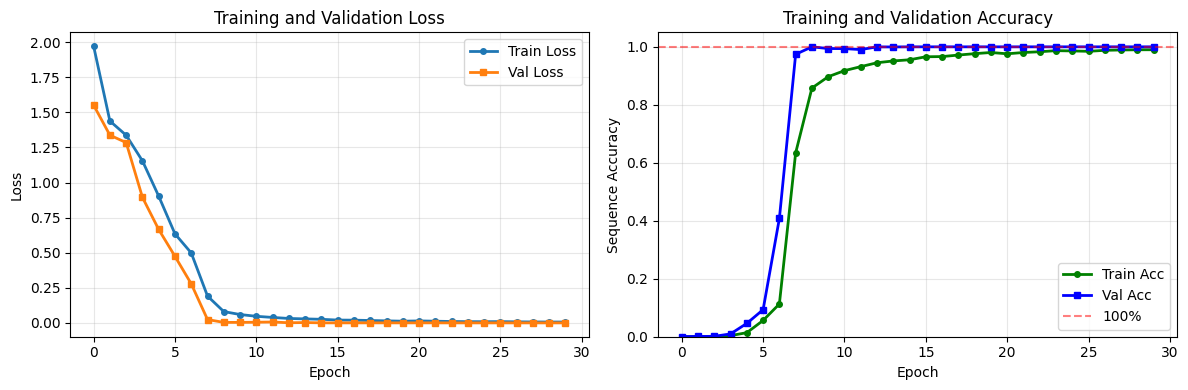

In [27]:
import matplotlib.pyplot as plt

# Plot training curves
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Plot 1: Loss (Train + Val)
ax1.plot(history['train_loss'], marker='o', linewidth=2, markersize=4, label='Train Loss')
ax1.plot(history['val_loss'], marker='s', linewidth=2, markersize=4, label='Val Loss')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.set_title('Training and Validation Loss')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Plot 2: Sequence Accuracy (Train + Val)
ax2.plot(history['train_seq_acc'], marker='o', linewidth=2, markersize=4, color='green', label='Train Acc')
ax2.plot(history['val_seq_acc'], marker='s', linewidth=2, markersize=4, color='blue', label='Val Acc')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Sequence Accuracy')
ax2.set_title('Training and Validation Accuracy')
ax2.set_ylim([0, 1.05])
ax2.axhline(y=1.0, color='r', linestyle='--', alpha=0.5, label='100%')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_curves.png', dpi=150, bbox_inches='tight')
plt.show()

In [28]:
def print_sample_predictions(model, dataset, tokenizer, device, num_samples=5):
    """Print sample predictions to see how model is doing"""
    model.eval()
    print("SAMPLE PREDICTIONS")

    indices = torch.randperm(len(dataset))[:num_samples]

    with torch.no_grad():
        for idx in indices:
            input_ids, target_ids = dataset[idx]
            input_ids_tensor = input_ids.unsqueeze(0).to(device)

            logits = model(input_ids_tensor)
            predictions = logits.argmax(dim=-1).squeeze(0)

            # Create mask for non-ignored tokens
            mask = target_ids != -100

            original_input, original_output = dataset.data[idx]

            # Extract target tokens (only non-masked positions)
            target_tokens = target_ids[mask].cpu().tolist()

            # Extract predicted tokens (same positions)
            pred_tokens = predictions[mask].cpu().tolist()

            target_text = tokenizer.decode(target_tokens)
            pred_text = tokenizer.decode(pred_tokens)

            # Display
            print(f"Problem:     {original_input}")
            print(f"Expected:    {original_output}")
            print(f"Target:      {target_text}")
            print(f"Predicted:   {pred_text}")

In [29]:
checkpoint = torch.load('best_model.pt')
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()

print("IN-DISTRIBUTION TEST SET EVALUATION")

test_dataset = AdditionDataset(test_data, tokenizer, max_length=32)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)
# Evaluate on test set
test_loss, test_char_acc, test_seq_acc = evaluate(
    model, test_loader, criterion, tokenizer, device
)
print(len(test_loader))
print(f"\nTest Results:")
print(f"  Loss: {test_loss:.4f}")
print(f"  Character Accuracy: {test_char_acc:.4f}")
print(f"  Sequence Accuracy: {test_seq_acc:.4f}")

print_sample_predictions(model, test_dataset, tokenizer, device, num_samples=3)

IN-DISTRIBUTION TEST SET EVALUATION


Evaluating: 100%|██████████| 118/118 [00:05<00:00, 22.09it/s]

118

Test Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     8278 + 4768 =
Expected:    13046
Target:      13046
Predicted:   13046
Problem:     6511 + 3580 =
Expected:    10091
Target:      10091
Predicted:   10091
Problem:     1272 + 5799 =
Expected:    7071
Target:      7071
Predicted:   7071


In [34]:
def generate_length_generalization_data(k, num_samples=1000):
    """Generate k-digit addition problems"""
    data = []
    min_val = 10 ** (k - 1)
    max_val = 10 ** k - 1

    for _ in range(num_samples):
        a = random.randint(min_val, max_val)
        b = random.randint(min_val, max_val)
        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

# Test on 5-digit numbers (k+1)
print("LENGTH GENERALIZATION: 5-DIGIT NUMBERS (k+1)")

k5_data = generate_length_generalization_data(k=5, num_samples=1000)
k5_dataset = AdditionDataset(k5_data, tokenizer, max_length=32)
k5_loader = DataLoader(k5_dataset, batch_size=128, shuffle=False)

k5_loss, k5_char_acc, k5_seq_acc = evaluate(
    model, k5_loader, criterion, tokenizer, device
)

print(f"\n5-Digit Results:")
print(f"  Loss: {k5_loss:.4f}")
print(f"  Character Accuracy: {k5_char_acc:.4f}")
print(f"  Sequence Accuracy: {k5_seq_acc:.4f}")

print_sample_predictions(model, k5_dataset, tokenizer, device, num_samples=3)

# Test on 6-digit numbers (k+2)
print("LENGTH GENERALIZATION: 6-DIGIT NUMBERS (k+2)")

k6_data = generate_length_generalization_data(k=6, num_samples=1000)
k6_dataset = AdditionDataset(k6_data, tokenizer, max_length=32)
k6_loader = DataLoader(k6_dataset, batch_size=128, shuffle=False)

k6_loss, k6_char_acc, k6_seq_acc = evaluate(
    model, k6_loader, criterion, tokenizer, device
)

print(f"\n6-Digit Results:")
print(f"  Loss: {k6_loss:.4f}")
print(f"  Character Accuracy: {k6_char_acc:.4f}")
print(f"  Sequence Accuracy: {k6_seq_acc:.4f}")

print_sample_predictions(model, k6_dataset, tokenizer, device, num_samples=3)

LENGTH GENERALIZATION: 5-DIGIT NUMBERS (k+1)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.15it/s]



5-Digit Results:
  Loss: 13.1504
  Character Accuracy: 0.1579
  Sequence Accuracy: 0.0000
SAMPLE PREDICTIONS
Problem:     86598 + 49178 =
Expected:    135776
Target:      135776
Predicted:   1100
Problem:     18286 + 34673 =
Expected:    52959
Target:      52959
Predicted:   744
Problem:     57704 + 64548 =
Expected:    122252
Target:      122252
Predicted:   1545
LENGTH GENERALIZATION: 6-DIGIT NUMBERS (k+2)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 19.57it/s]


6-Digit Results:
  Loss: 12.3674
  Character Accuracy: 0.1520
  Sequence Accuracy: 0.0000
SAMPLE PREDICTIONS
Problem:     464991 + 169547 =
Expected:    634538
Target:      634538
Predicted:   94
Problem:     867178 + 864226 =
Expected:    1731404
Target:      1731404
Predicted:   17
Problem:     147654 + 800606 =
Expected:    948260
Target:      948260
Predicted:   7666


In [32]:
# I just checked if 4-digit addition is working if first digit is 0 -> learnt well
def generate_length_generalization_data(k, num_samples=1000):
    """Generate k-digit addition problems"""
    data = []
    min_val = 10 ** (k - 1)
    max_val = 10 ** k - 1

    for _ in range(num_samples):
        a = random.randint(min_val, max_val)
        b = random.randint(min_val, max_val)
        c = a + b
        input_str = f"0{a} + 0{b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

In [35]:
k3_data = generate_length_generalization_data(k=3, num_samples=700)
print(k3_data[0])
k3_dataset = AdditionDataset(k3_data, tokenizer, max_length=32)
k3_loader = DataLoader(k3_dataset, batch_size=128, shuffle=False)

k3_loss, k3_char_acc, k3_seq_acc = evaluate(
    model, k3_loader, criterion, tokenizer, device
)

print(f"\n3-Digit Results:")
print(f"  Loss: {k3_loss:.4f}")
print(f"  Character Accuracy: {k3_char_acc:.4f}")
print(f"  Sequence Accuracy: {k3_seq_acc:.4f}")

print_sample_predictions(model, k3_dataset, tokenizer, device, num_samples=5)

('703 + 196 =', '899')


Evaluating: 100%|██████████| 6/6 [00:00<00:00, 29.02it/s]


3-Digit Results:
  Loss: 11.6009
  Character Accuracy: 0.1620
  Sequence Accuracy: 0.0000
SAMPLE PREDICTIONS
Problem:     828 + 332 =
Expected:    1160
Target:      1160
Predicted:   1156
Problem:     720 + 280 =
Expected:    1000
Target:      1000
Predicted:   14920
Problem:     873 + 214 =
Expected:    1087
Target:      1087
Predicted:   10916
Problem:     551 + 297 =
Expected:    848
Target:      848
Predicted:   1122
Problem:     203 + 664 =
Expected:    867
Target:      867
Predicted:   8584


In [36]:
# results in json
import json

results = {
    "metadata": {
        "model_config": {
            "d_model": 128,
            "nhead": 4,
            "num_layers": 6,
            "dim_feedforward": 512,
            "dropout": 0.1,
            "total_params": total_params,
            "pos_encoding": "learned"
        },
        "training_config": {
            "num_samples": num_samples,
            "train_size": len(train_data),
            "val_size": len(val_data),
            "test_size": len(test_data),
            "batch_size": batch_size,
            "learning_rate": 1e-3,
            "weight_decay": 1e-5,
            "epochs_trained": checkpoint['epoch'] + 1
        }
    },
    "evaluation": {
        "in_distribution": {
            "description": "4-digit addition (trained on)",
            "num_samples": len(test_data),
            "loss": float(test_loss),
            "character_accuracy": float(test_char_acc),
            "sequence_accuracy": float(test_seq_acc)
        },
        "length_generalization_k_minus_1": {
            "description": "3-digit addition (k-1 generalization)",
            "num_samples": 700,
            "loss": float(k3_loss),
            "character_accuracy": float(k3_char_acc),
            "sequence_accuracy": float(k3_seq_acc)
        },
        "length_generalization_k_plus_1": {
            "description": "5-digit addition (k+1 generalization)",
            "num_samples": 1000,
            "loss": float(k5_loss),
            "character_accuracy": float(k5_char_acc),
            "sequence_accuracy": float(k5_seq_acc)
        },
        "length_generalization_k_plus_2": {
            "description": "6-digit addition (k+2 generalization)",
            "num_samples": 1000,
            "loss": float(k6_loss),
            "character_accuracy": float(k6_char_acc),
            "sequence_accuracy": float(k6_seq_acc)
        }
    },
    "best_checkpoint": {
        "epoch": checkpoint['epoch'],
        "train_seq_acc": float(checkpoint['train_seq_acc']),
        "val_seq_acc": float(checkpoint['val_seq_acc'])
    }
}

with open('results.json', 'w') as f:
    json.dump(results, indent=2, fp=f)

print("\n Results saved to results.json")

print(f"4-digit (in-dist):  {test_seq_acc:.2%}")
print(f"5-digit (k+1):      {k5_seq_acc:.2%}")
print(f"6-digit (k+2):      {k6_seq_acc:.2%}")


 Results saved to results.json
4-digit (in-dist):  100.00%
5-digit (k+1):      0.00%
6-digit (k+2):      0.00%


In [38]:
def generate_hard_carry_data(num_samples=1000):
    """Generate additions with many 9s (difficult carries)"""
    data = []

    for _ in range(num_samples):
        # Generate numbers with high probability of 9s
        a_digits = [random.choice([9, 9, 9, random.randint(0, 9)]) for _ in range(4)]
        b_digits = [random.choice([9, 9, 9, random.randint(0, 9)]) for _ in range(4)]

        a = int(''.join(map(str, a_digits)))
        b = int(''.join(map(str, b_digits)))

        # Ensure 4 digits
        if a < 1000:
            a += 1000
        if b < 1000:
            b += 1000

        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

print("DISTRIBUTION SHIFT: MANY 9s (HARD CARRIES)")

hard_carry_data = generate_hard_carry_data(num_samples=1000)
hard_carry_dataset = AdditionDataset(hard_carry_data, tokenizer, max_length=32)
hard_carry_loader = DataLoader(hard_carry_dataset, batch_size=128, shuffle=False)

hc_loss, hc_char_acc, hc_seq_acc = evaluate(
    model, hard_carry_loader, criterion, tokenizer, device
)

print(f"\nHard Carry Results:")
print(f"  Loss: {hc_loss:.4f}")
print(f"  Character Accuracy: {hc_char_acc:.4f}")
print(f"  Sequence Accuracy: {hc_seq_acc:.4f}")

print_sample_predictions(model, hard_carry_dataset, tokenizer, device, num_samples=5)

DISTRIBUTION SHIFT: MANY 9s (HARD CARRIES)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.15it/s]


Hard Carry Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     2999 + 9999 =
Expected:    12998
Target:      12998
Predicted:   12998
Problem:     9979 + 9999 =
Expected:    19978
Target:      19978
Predicted:   19978
Problem:     9999 + 9999 =
Expected:    19998
Target:      19998
Predicted:   19998
Problem:     9879 + 9999 =
Expected:    19878
Target:      19878
Predicted:   19878
Problem:     9999 + 9999 =
Expected:    19998
Target:      19998
Predicted:   19998


In [37]:
def generate_small_numbers_data(num_samples=1000):
    """Generate additions with small numbers (1000-3000)"""
    data = []

    for _ in range(num_samples):
        a = random.randint(1000, 3000)
        b = random.randint(1000, 3000)
        c = a + b
        input_str = f"{a} + {b} ="
        output_str = str(c)
        data.append((input_str, output_str))

    return data

print("DISTRIBUTION SHIFT: SMALL NUMBERS ONLY (1000-3000)")

small_data = generate_small_numbers_data(num_samples=1000)
small_dataset = AdditionDataset(small_data, tokenizer, max_length=32)
small_loader = DataLoader(small_dataset, batch_size=128, shuffle=False)

small_loss, small_char_acc, small_seq_acc = evaluate(
    model, small_loader, criterion, tokenizer, device
)

print(f"\nSmall Numbers Results:")
print(f"  Loss: {small_loss:.4f}")
print(f"  Character Accuracy: {small_char_acc:.4f}")
print(f"  Sequence Accuracy: {small_seq_acc:.4f}")

print_sample_predictions(model, small_dataset, tokenizer, device, num_samples=5)

DISTRIBUTION SHIFT: SMALL NUMBERS ONLY (1000-3000)


Evaluating: 100%|██████████| 8/8 [00:00<00:00, 22.30it/s]


Small Numbers Results:
  Loss: 0.0000
  Character Accuracy: 1.0000
  Sequence Accuracy: 1.0000
SAMPLE PREDICTIONS
Problem:     1188 + 1340 =
Expected:    2528
Target:      2528
Predicted:   2528
Problem:     1757 + 2675 =
Expected:    4432
Target:      4432
Predicted:   4432
Problem:     1174 + 1042 =
Expected:    2216
Target:      2216
Predicted:   2216
Problem:     1589 + 1859 =
Expected:    3448
Target:      3448
Predicted:   3448
Problem:     2914 + 1051 =
Expected:    3965
Target:      3965
Predicted:   3965
